# Book Rating Prediction

## Data Cleansing

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

ModuleNotFoundError: No module named 'fastai'

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import requests
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from os import listdir
from os.path import isfile, join
np.random.seed(42)

In [106]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Identify the bookIDs of downloaded images

In [4]:
#identify the book ids of the downloaded books
jpg_list = [f for f in listdir('./data/Grant/cover_images/') if isfile(join('./data/Grant/cover_images/', f)) and f != '4232.jpg']

downloaded_images = pd.Series(list(map(int,[i[:-4] for i in jpg_list])))

In [5]:
#count of book cover images
len(jpg_list)

10599

### Read Goodreads dataframe and merge with jpg list

In [107]:
goodreads = pd.read_csv('./data/Grant/books.csv', error_bad_lines=False)

#merges the goodreads reviews with the pic features
cover_df = goodreads[goodreads['bookID'].isin(list(downloaded_images))]
cover_df['file_name'] = cover_df['bookID'].astype(str) + '.jpg'

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Create calculated targets

In [108]:
#rating mean norm
cover_df['average_rating_mean_norm'] = (cover_df['average_rating']-cover_df['average_rating'].mean())/cover_df['average_rating'].std()

#rating min-max norm
cover_df['average_rating_min_max'] = (cover_df['average_rating']-cover_df['average_rating'].min())/(cover_df['average_rating'].max()-cover_df['average_rating'].min())

#rating thirds
cover_df['average_rating_thirds'] = pd.qcut(cover_df['average_rating'], 3, labels=False).astype('str')

#count log
cover_df['ratings_count_log'] = (cover_df['ratings_count']+1).apply(np.log)

#count thirds
cover_df['ratings_count_thirds'] = pd.qcut(cover_df['ratings_count'], 3, labels=False).astype('str')

#summed thirds
cover_df['summed_thirds'] = (cover_df['average_rating_thirds'].astype('int') 
                                       + cover_df['ratings_count_thirds'].astype('int'))

cover_df.head()

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,file_name,average_rating_mean_norm,average_rating_min_max,average_rating_thirds,ratings_count_log,ratings_count_thirds,summed_thirds
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.,1.jpg,1.831714,0.914,2,14.555394,2,4
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.,2.jpg,1.600537,0.898,2,14.582451,2,4
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic,4.jpg,1.398257,0.884,2,8.753687,2,4
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.,5.jpg,1.802817,0.912,2,14.665485,2,4
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic,8.jpg,2.438554,0.956,2,10.631736,2,4


# Average Rating Regression

### Create image data object from cover_df and cover_images folder with a random validation set, 192x128 padded images, batch size of 12, and normalized pixel values

In [9]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('average_rating', label_cls=FloatList)
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))                          

### Example book covers and their average ratings

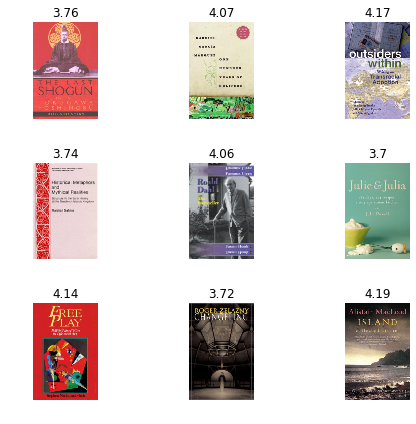

In [10]:
data.show_batch(rows=3, figsize=(7,6))

### Create CNN built from the resnet34 architecture

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=root_mean_squared_error)

### Identify a reasonable learning rate

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


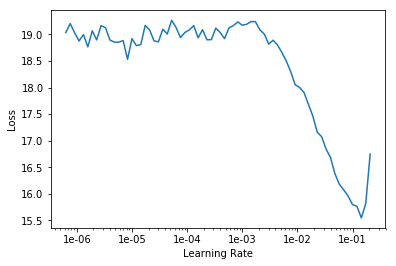

In [12]:
learn.recorder.plot()

In [13]:
lr = 1e-3

### Fit for 5 epochs

In [ ]:
learn.fit_one_cycle(5, slice(lr))

### Save the initial model

In [ ]:
learn.save('average_rating-stage-1')

### Load in initial model for analysis & additional training

In [12]:
learn.load('average_rating-stage-1');

### Show example predictions compared to actual

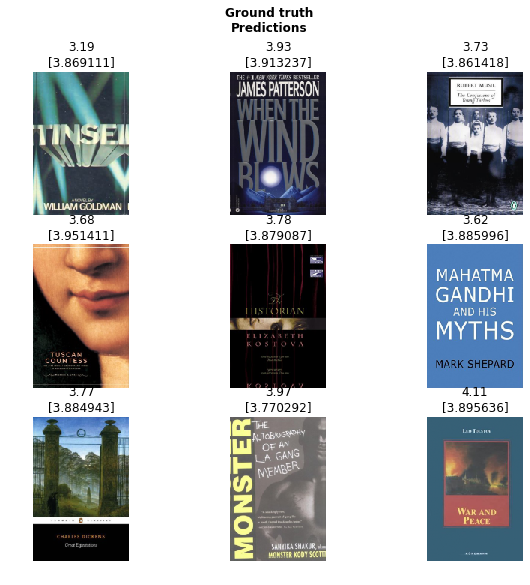

In [13]:
learn.show_results(rows=3, figsize=(10,9))

### Gather predictions from the validation set

In [14]:
preds_average_rating = learn.get_preds()

### Save actuals, predictions, and errors into a df

In [15]:
validation = pd.DataFrame(preds_average_rating[1].T.tolist(), columns=['average_rating_actual'])
validation['average_rating_predicted'] = preds_average_rating[0].T.tolist()[0]
validation['average_rating_error'] = validation['average_rating_actual'] - validation['average_rating_predicted']

validation.head()

,average_rating_actual,average_rating_predicted,average_rating_error
0,3.19,3.869111,-0.679111
1,3.93,3.913237,0.016763
2,3.73,3.861418,-0.131418
3,3.68,3.951411,-0.271411
4,3.78,3.879087,-0.099087


# Average Rating Mean Norm Regression

In [16]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('average_rating_mean_norm', label_cls=FloatList)
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))                          

In [17]:
learn = cnn_learner(data, models.resnet34, metrics=root_mean_squared_error)

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


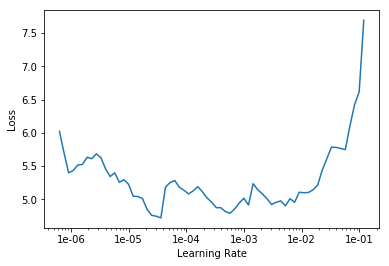

In [31]:
learn.recorder.plot()

In [32]:
lr = 2e-4

In [33]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.308100,1.496886,1.148950,00:49
1,2.180748,1.242882,1.034975,00:49
2,1.421306,1.108001,0.970337,00:50
3,1.290652,1.030852,0.927924,00:50
4,1.495838,1.013770,0.918401,00:50


In [34]:
learn.save('average_rating_mean_norm-stage-1')

In [18]:
learn.load('average_rating_mean_norm-stage-1');

In [19]:
preds_average_rating_mean_norm = learn.get_preds()

In [20]:
validation['average_rating_mean_norm_actual'] = preds_average_rating_mean_norm[1].T.tolist()
validation['average_rating_mean_norm_predicted'] = preds_average_rating_mean_norm[0].T.tolist()[0]
validation['average_rating_mean_norm_error'] = validation['average_rating_mean_norm_actual'] - validation['average_rating_mean_norm_predicted']

# Avg Rating Min Max Norm Regression

In [21]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('average_rating_min_max', label_cls=FloatList)
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=root_mean_squared_error)

In [32]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


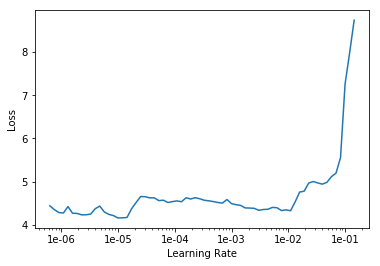

In [33]:
learn.recorder.plot()

In [34]:
lr=1e-3

In [35]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,1.307910,0.347857,0.576075,00:49
1,0.039625,0.013984,0.113795,00:49
2,0.013925,0.010188,0.097132,00:49
3,0.007281,0.005812,0.071279,00:49
4,0.004849,0.004581,0.061233,00:49


In [36]:
learn.save('average_rating_min_max-stage-1')

In [24]:
learn.load('average_rating_min_max-stage-1');

In [25]:
preds_average_rating_min_max = learn.get_preds();

In [26]:
validation['average_rating_min_max_actual'] = preds_average_rating_min_max[1].T.tolist()
validation['average_rating_min_max_predicted'] = preds_average_rating_min_max[0].T.tolist()[0]
validation['average_rating_min_max_error'] = validation['average_rating_min_max_actual'] - validation['average_rating_min_max_predicted']

# Average Rating Segment Classification

In [66]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('average_rating_thirds')
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

In [67]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [49]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


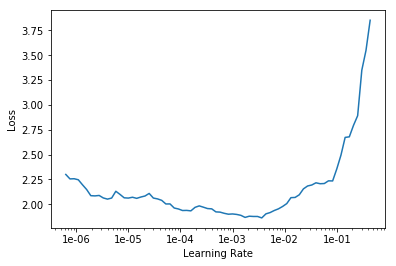

In [50]:
learn.recorder.plot()

In [51]:
lr=2e-5

In [52]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.904176,1.431168,0.337423,00:49
1,1.791028,1.351459,0.352525,00:50
2,1.785292,1.319173,0.345446,00:50
3,1.794178,1.305964,0.350165,00:50
4,1.747106,1.308340,0.359132,00:50


In [53]:
learn.save('average_rating_thirds-stage-1')

In [29]:
learn.load('average_rating_thirds-stage-1');

In [30]:
preds_average_rating_thirds = learn.get_preds()

### Identify the predicted class based on the max probability for each sample in the validation set

In [31]:
learn.data.classes

['0', '1', '2']

In [32]:
preds_average_rating_thirds_list = preds_average_rating_thirds[0].tolist()
average_rating_thirds_output = []
for probs in preds_average_rating_thirds_list:
    label = learn.data.classes[probs.index(max(probs))]
    average_rating_thirds_output.append(label)

In [33]:
validation['average_rating_thirds_actual'] = preds_average_rating_thirds[1].T.tolist()
validation['average_rating_thirds_predicted'] = average_rating_thirds_output
validation['average_rating_thirds_error'] = validation['average_rating_thirds_actual'].astype('int') - validation['average_rating_thirds_predicted'].astype('int')

# Rating Count Regression

In [34]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('ratings_count', label_cls=FloatList)
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

In [35]:
learn = cnn_learner(data, models.resnet34, metrics=root_mean_squared_error)

In [86]:
learn.lr_find(stop_div=False, num_it=200)

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


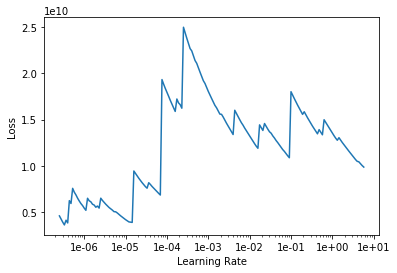

In [87]:
learn.recorder.plot()

In [88]:
lr=2e-4

In [89]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,7054154240.000000,26009393152.000000,57941.351562,00:49
1,5897179648.000000,26009227264.000000,57939.980469,00:49
2,5032824320.000000,26009055232.000000,57938.335938,00:50
3,12760754176.000000,26008940544.000000,57937.390625,00:50
4,14156739584.000000,26008954880.000000,57937.523438,00:50


In [90]:
learn.save('ratings_count-stage-1')

In [36]:
learn.load('ratings_count-stage-1');

In [37]:
preds_ratings_count = learn.get_preds()

In [38]:
validation['ratings_count_actual'] = preds_ratings_count[1].T.tolist()
validation['ratings_count_predicted'] = preds_ratings_count[0].T.tolist()[0]
validation['ratings_count_error'] = validation['ratings_count_actual'] - validation['ratings_count_predicted']

# Ratings Count Log Regression

In [39]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('ratings_count_log', label_cls=FloatList)
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

In [40]:
learn = cnn_learner(data, models.resnet34, metrics=root_mean_squared_error)

In [95]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


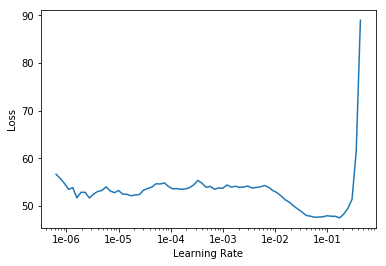

In [96]:
learn.recorder.plot()

In [97]:
lr=6e-3

In [98]:
learn.fit_one_cycle(8, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,11.261992,8.519144,2.847971,00:49
1,8.746693,7.158693,2.624527,00:50
2,8.173185,6.576440,2.516423,00:49
3,7.439196,6.902674,2.571049,00:50
4,6.685098,6.150492,2.433302,00:50
5,6.157009,6.343578,2.467921,00:50
6,5.830533,6.231979,2.444824,00:50
7,5.034369,6.312810,2.462475,00:50


In [99]:
learn.save('ratings_count_log-stage-1')

In [41]:
learn.load('ratings_count_log-stage-1');

In [42]:
preds_ratings_count_log = learn.get_preds()

In [43]:
validation['ratings_count_log_actual'] = preds_ratings_count_log[1].T.tolist()
validation['ratings_count_log_predicted'] = preds_ratings_count_log[0].T.tolist()[0]
validation['ratings_count_log_error'] = validation['ratings_count_log_actual'] - validation['ratings_count_log_predicted']

# Ratings Count Segment Classification

In [69]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('ratings_count_thirds')
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

In [70]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [104]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


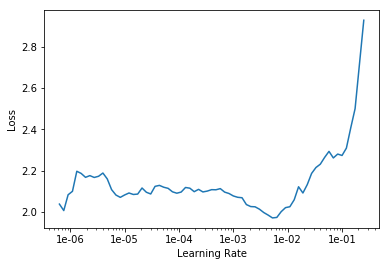

In [105]:
learn.recorder.plot()

In [107]:
lr=7e-4

In [108]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.644649,1.292829,0.370930,00:49
1,1.230669,1.123699,0.391222,00:49
2,1.102447,1.091656,0.397829,00:49
3,1.084685,1.064058,0.417178,00:50
4,1.047142,1.065024,0.419066,00:50


In [109]:
learn.save('ratings_count_thirds-stage-1')

In [46]:
learn.load('ratings_count_thirds-stage-1');

In [47]:
preds_ratings_count_thirds = learn.get_preds()

In [48]:
preds_ratings_count_thirds_list = preds_ratings_count_thirds[0].tolist()
ratings_count_thirds_output = []
for probs in preds_ratings_count_thirds_list:
    label = learn.data.classes[probs.index(max(probs))]
    ratings_count_thirds_output.append(label)

In [49]:
validation['ratings_count_thirds_actual'] = preds_ratings_count_thirds[1].T.tolist()
validation['ratings_count_thirds_predicted'] = ratings_count_thirds_output
validation['ratings_count_thirds_error'] = validation['ratings_count_thirds_actual'].astype('int') - validation['ratings_count_thirds_predicted'].astype('int')

# Summed Thirds Regression

In [50]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('summed_thirds', label_cls=FloatList)
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

In [51]:
learn = cnn_learner(data, models.resnet34, metrics=root_mean_squared_error)

In [166]:
learn.lr_find()

epoch,train_loss,valid_loss,root_mean_squared_error,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


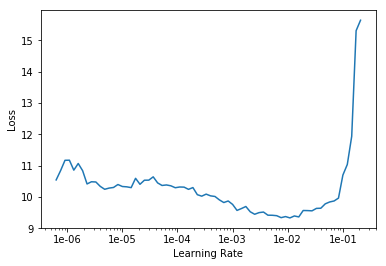

In [167]:
learn.recorder.plot()

In [168]:
lr=3e-4

In [169]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,4.738353,2.682266,1.610911,00:49
1,2.929822,1.734174,1.296109,00:49
2,2.068235,1.594893,1.245628,00:50
3,1.687977,1.474759,1.198055,00:49
4,1.744627,1.458652,1.191442,00:50


In [170]:
learn.save('summed_thirds-stage-1')

In [52]:
learn.load('summed_thirds-stage-1');

In [53]:
preds_summed_thirds = learn.get_preds()

In [54]:
validation['summed_thirds_actual'] = preds_summed_thirds[1].T.tolist()
validation['summed_thirds_predicted'] = preds_summed_thirds[0].T.tolist()[0]
validation['summed_thirds_error'] = validation['summed_thirds_actual'] - validation['summed_thirds_predicted']

# Error Analysis

### Three columns for the 8 models, each trained on a different target variable

In [56]:
validation.head()

,average_rating_actual,average_rating_predicted,average_rating_error,average_rating_mean_norm_actual,average_rating_mean_norm_predicted,average_rating_mean_norm_error,average_rating_min_max_actual,average_rating_min_max_predicted,average_rating_min_max_error,average_rating_thirds_actual,...,ratings_count_error,ratings_count_log_actual,ratings_count_log_predicted,ratings_count_log_error,ratings_count_thirds_actual,ratings_count_thirds_predicted,ratings_count_thirds_error,summed_thirds_actual,summed_thirds_predicted,summed_thirds_error
0,3.19,3.869111,-0.679111,-2.156091,-0.178756,-1.977334,0.638,0.779590,-0.141590,0,...,242.910259,5.556828,5.669161,-0.112333,1,1,0,1.0,1.870722,-0.870722
1,3.93,3.913237,0.016763,-0.017703,-0.033645,0.015943,0.786,0.787504,-0.001504,1,...,42680.130302,10.662001,8.425425,2.236576,2,2,0,3.0,2.273115,0.726885
2,3.73,3.861418,-0.131418,-0.595645,-0.110103,-0.485542,0.746,0.788915,-0.042915,0,...,4362.384336,8.383662,6.245042,2.138620,2,1,1,2.0,2.093298,-0.093298
3,3.68,3.951411,-0.271411,-0.740131,0.152656,-0.892787,0.736,0.786955,-0.050955,0,...,31.549915,3.951244,4.988267,-1.037023,0,0,0,0.0,1.095698,-1.095698
4,3.78,3.879087,-0.099087,-0.451160,-0.172110,-0.279049,0.756,0.774076,-0.018076,0,...,343.268547,5.872118,4.953963,0.918155,1,0,1,1.0,1.649893,-0.649893


In [57]:
validation.describe()

,average_rating_actual,average_rating_predicted,average_rating_error,average_rating_mean_norm_actual,average_rating_mean_norm_predicted,average_rating_mean_norm_error,average_rating_min_max_actual,average_rating_min_max_predicted,average_rating_min_max_error,average_rating_thirds_actual,...,ratings_count_predicted,ratings_count_error,ratings_count_log_actual,ratings_count_log_predicted,ratings_count_log_error,ratings_count_thirds_actual,ratings_count_thirds_error,summed_thirds_actual,summed_thirds_predicted,summed_thirds_error
count,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,...,2119.000000,2.119000e+03,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000,2119.000000
mean,3.950793,3.908533,0.042260,0.042383,0.033464,0.008918,0.790159,0.782875,0.007283,1.035394,...,6.218357,2.042077e+04,6.602323,6.536265,0.066058,0.991977,-0.078811,2.027371,1.890395,0.136976
std,0.333371,0.151398,0.356036,0.963347,0.351598,1.007060,0.066674,0.017951,0.067306,0.803188,...,13.731600,1.600126e+05,2.671358,1.457815,2.512255,0.806274,1.051066,1.181461,0.406282,1.200237
min,0.000000,3.347210,-3.958106,-11.374277,-1.206967,-11.383304,0.000000,0.702730,-0.786154,0.000000,...,-36.619640,-2.519406e+01,0.000000,0.245615,-7.859217,0.000000,-2.000000,0.000000,0.088018,-2.820401
25%,3.800000,3.803509,-0.133880,-0.393365,-0.192216,-0.506011,0.760000,0.771268,-0.025310,0.000000,...,-2.665255,1.101177e+02,4.736198,5.680943,-1.681291,0.000000,-1.000000,1.000000,1.639058,-0.767454
50%,3.980000,3.903531,0.066188,0.126783,0.019397,0.082926,0.796000,0.782983,0.012116,1.000000,...,7.034238,7.309279e+02,6.599871,6.535461,0.076580,1.000000,0.000000,2.000000,1.892482,0.153793
75%,4.140000,4.002146,0.255539,0.589137,0.262867,0.625181,0.828000,0.794072,0.047171,2.000000,...,15.882703,4.613219e+03,8.438034,7.440805,1.876979,2.000000,1.000000,3.000000,2.143487,1.070527
max,5.000000,4.610054,1.105941,3.074291,1.696287,3.282647,1.000000,0.850754,0.235816,2.000000,...,44.844086,4.597635e+06,15.341060,11.190114,8.684795,2.000000,2.000000,4.000000,3.246280,3.027336


In [58]:
validation.columns

Index(['average_rating_actual', 'average_rating_predicted',
       'average_rating_error', 'average_rating_mean_norm_actual',
       'average_rating_mean_norm_predicted', 'average_rating_mean_norm_error',
       'average_rating_min_max_actual', 'average_rating_min_max_predicted',
       'average_rating_min_max_error', 'average_rating_thirds_actual',
       'average_rating_thirds_predicted', 'average_rating_thirds_error',
       'ratings_count_actual', 'ratings_count_predicted',
       'ratings_count_error', 'ratings_count_log_actual',
       'ratings_count_log_predicted', 'ratings_count_log_error',
       'ratings_count_thirds_actual', 'ratings_count_thirds_predicted',
       'ratings_count_thirds_error', 'summed_thirds_actual',
       'summed_thirds_predicted', 'summed_thirds_error'],
      dtype='object')

### Comparing the distribution of actual vs predicted for the regression models

In [59]:
def book_cover_distplot(title, data1, data2):
    sns.set()
    sns.set_style('ticks')
    sns.distplot(data1, label='actual')
    sns.distplot(data2, label='predicted')
    plt.legend()
    plt.title(title)
    plt.xlabel('')
    sns.despine()

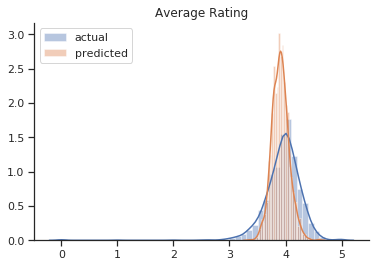

In [60]:
book_cover_distplot('Average Rating', validation['average_rating_actual'], validation['average_rating_predicted'])

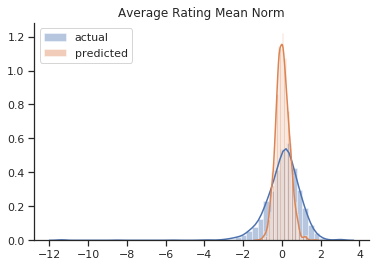

In [61]:
book_cover_distplot('Average Rating Mean Norm', validation['average_rating_mean_norm_actual'], validation['average_rating_mean_norm_predicted'])

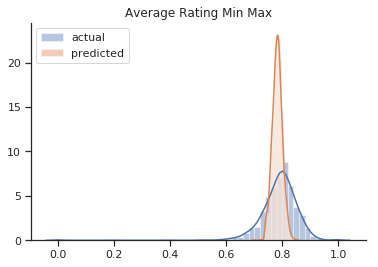

In [62]:
book_cover_distplot('Average Rating Min Max', validation['average_rating_min_max_actual'], validation['average_rating_min_max_predicted'])

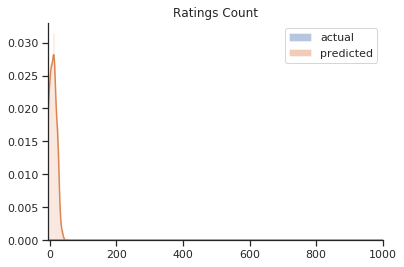

In [63]:
book_cover_distplot('Ratings Count', validation['ratings_count_actual'], validation['ratings_count_predicted'])
plt.xlim(-5, 1000);

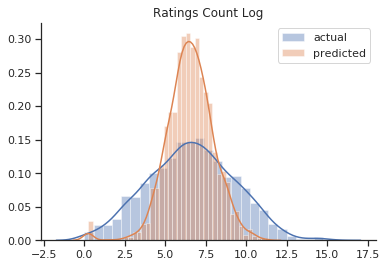

In [64]:
book_cover_distplot('Ratings Count Log', validation['ratings_count_log_actual'], validation['ratings_count_log_predicted'])

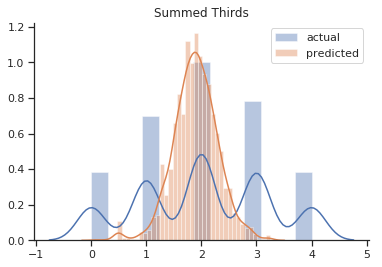

In [65]:
book_cover_distplot('Summed Thirds', validation['summed_thirds_actual'], validation['summed_thirds_predicted'])

### Generating confusion matrices for the classification models

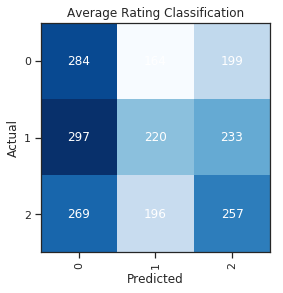

In [68]:
learn.load('average_rating_thirds-stage-1')
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix(title='Average Rating Classification')

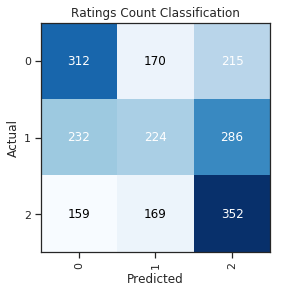

In [71]:
learn.load('ratings_count_thirds-stage-1')
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix(title='Ratings Count Classification')

### Rating Count Classification looks the least bad (42% accuracy); all other models center heavily around the mean. Next step: reloading the CNN and doing additional training

# Additional Training

### Reload the number of ratings segment CNN classifier

In [88]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('ratings_count_thirds')
        .transform(size=(192, 128), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.load('ratings_count_thirds-stage-1');

### Unfreeze the earlier resnet layers

In [89]:
learn.unfreeze()

In [90]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


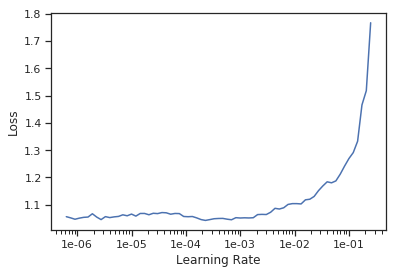

In [91]:
learn.recorder.plot()

### Train the full CNN for 2 epochs

In [92]:
learn.fit_one_cycle(2, slice(4e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.073790,1.054939,0.437470,01:18
1,0.907857,1.050581,0.460123,01:18


In [93]:
learn.save('ratings_count_thirds-stage-2')

In [94]:
learn.load('ratings_count_thirds-stage-2');

### Recreate the dataset using larger images

In [95]:
data = (ImageList.from_df(cover_df, './data/Grant/cover_images', cols='file_name')
        .split_by_rand_pct(seed=42)
        .label_from_df('ratings_count_thirds')
        .transform(size=(384, 256), padding_mode='reflection', resize_method=ResizeMethod.PAD)
        .databunch(bs=12).normalize(imagenet_stats))  

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 384, 256])

### Refreeze and train the last couple layers

In [96]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


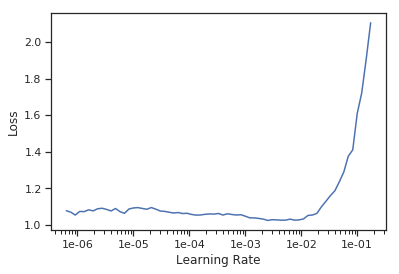

In [97]:
learn.lr_find()
learn.recorder.plot()

In [98]:
learn.fit_one_cycle(3, slice(2e-5, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.119444,1.129642,0.428032,02:12
1,1.038796,1.082251,0.430864,02:12
2,1.003637,1.062213,0.443605,02:12


### View loss over time

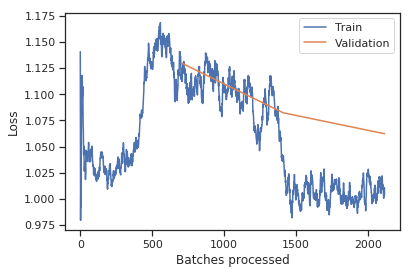

In [99]:
learn.recorder.plot_losses()

### Plot of the top losses

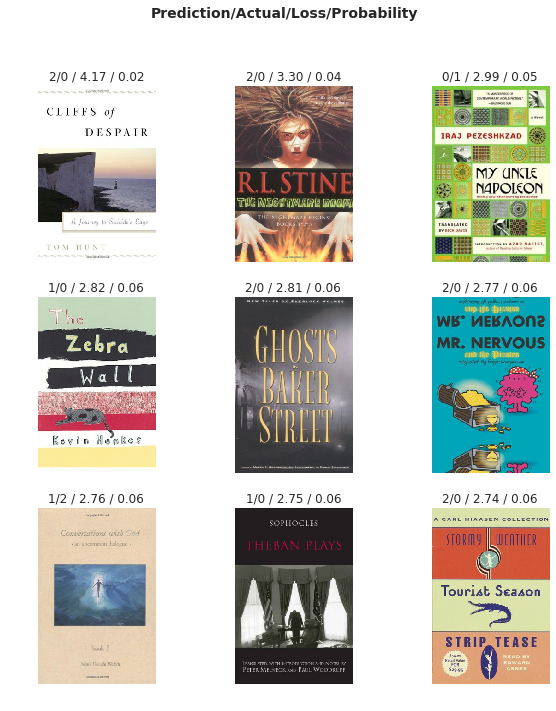

In [105]:
interp.plot_top_losses(9, figsize=(10,11))

### Based on the Confusion Matrix, it looks like the worst mistakes (e.g. predicts a 2 but the actual is 0) are the least frequent

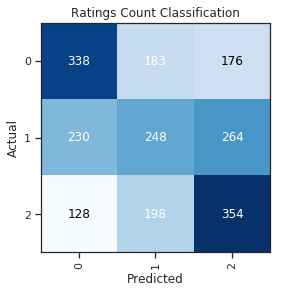

In [102]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix(title='Ratings Count Classification')

### Save and export this model with a 44% accuracy rate

In [111]:
learn.save('ratings_count_segment-256-stage-1')

In [112]:
learn.export()